# Optimize EfficientDet with OpenVINO™
EfficientDets are a family of object detection models, which achieve state-of-the-art 55.1mAP on COCO test-dev, yet being 4x - 9x smaller and using 13x - 42x fewer FLOPs than previous detectors. Our models also run 2x - 4x faster on GPU, and 5x - 11x faster on CPU than other detectors.

In this notebook you will learn how to use EfficientDet model and optimize it with OpenVINO API

###The tutorial consists of the following steps:

* Downloading and exporting efficientDet-d0 model
* loading efficintDet-d0 into tensorflow
  * Validating inference of tf-model
* Converting tf-model to OpenVINO-IR(Intermidiate representation) file {FP16}
  * Validating inference of OpenVINO-model
  * Evaluating performance by AP( average Percesion)
* Post-training optimization with OpenVINO NNCF (Neural Network Compression Framework)
  * Quantization of FP16 model to INT8 model
  * Validating Inference of INT8 model
  * Evaluating performance of INT8 model by AP
* Compare performance of the FP32 and quantized model with OpenVINO benchmark_app

###Prerequisites

In [ ]:
!pip install --upgrade scipy==1.9.0
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pathlib
import json
import requests
import tarfile

In [2]:
# Download source code.
if not pathlib.Path('automl').exists():
    !git clone --depth 1 https://github.com/google/automl
    %cd automl/efficientdet
    !pip install -r requirements.txt
else:
    %cd automl/efficientdet

/content/automl/efficientdet


### Downloading and Exporting model
* First we Download a pretrained model of EfficientDet
* Then Export the dowloded model for further use

In [3]:
def download_file(URL:str):
    """
    Download file from URLs
    """
    file_name = URL.split('/')[-1]
    file_path = file_name

    responce = requests.get(URL)
    with open(file_path,'wb') as f:
        f.write(responce.content)

In [4]:
# downloading pretrained model


def download_model(model:str):
    if not pathlib.Path(model + '.tar.gz').exists():
        model_url = f'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{model}.tar.gz'
        download_file(URL=model_url)

        f = tarfile.open(f'{model}.tar.gz')
        f.extractall()
        f.close()

    ckpt_path = pathlib.Path.cwd() / model
    return ckpt_path  # checkpoint path


MODEL = 'efficientdet-d0' 
CKPT_PATH = download_model(model=MODEL)

print(f'Trained Model Path : {CKPT_PATH}')

Trained Model Path : /content/automl/efficientdet/efficientdet-d0


In [ ]:
SAVED_MODEL_DIR = pathlib.Path('savedmodel')
SAVED_MODEL_DIR.mkdir(exist_ok=True)

#export saved model.
!python model_inspect.py --runmode=saved_model \
    --model_name={MODEL} --ckpt_path={CKPT_PATH} \
    --hparams="image_size=512x512" \
    --saved_model_dir={SAVED_MODEL_DIR}

### Utility Function
* Image loder , load jpg images in tensor with uint8 dtype
* Visualizer , add bounding box and label on image

In [6]:
# COCO-2017 label
coco_label = {0:'__background__',1: 'person',2: 'bicycle',3: 'car',4: 'motorcycle',5: 'airplane',6: 'bus',7: 'train',8: 'truck',9: 'boat',
              10: 'traffic light',11: 'fire hydrant',12: 'street sign',13: 'stop sign',14: 'parking meter',15: 'bench',16: 'bird',
              17: 'cat',18: 'dog',19: 'horse',20: 'sheep',21: 'cow',22: 'elephant',23: 'bear',24: 'zebra',25: 'giraffe',
              26: 'hat',27: 'backpack',28: 'umbrella',29: 'shoe',30: 'eye glasses',31: 'handbag',32: 'tie',33: 'suitcase',34: 'frisbee',
              35: 'skis',36: 'snowboard',37: 'sports ball',38: 'kite',39: 'baseball bat',40: 'baseball glove',41: 'skateboard',42: 'surfboard',
              43: 'tennis racket',44: 'bottle',45: 'plate',46: 'wine glass',47: 'cup',48: 'fork',49: 'knife',50: 'spoon',51: 'bowl',
              52: 'banana',53: 'apple',54: 'sandwich',55: 'orange',56: 'broccoli',57: 'carrot',58: 'hot dog',59: 'pizza',60: 'donut',
              61: 'cake',62: 'chair',63: 'couch',64: 'potted plant',65: 'bed',66: 'mirror',67: 'dining table',68: 'window',69: 'desk',70: 'toilet',
              71: 'door',72: 'tv',73: 'laptop',74: 'mouse',75: 'remote',76: 'keyboard',77: 'cell phone',78: 'microwave',79: 'oven',80: 'toaster',
              81: 'sink',82: 'refrigerator',83: 'blender',84: 'book',85: 'clock',86: 'vase',87: 'scissors',88: 'teddy bear',89: 'hair drier',90: 'toothbrush',91: 'hair brush',}

label_color = {i: [np.random.randint(0, 255) for _ in range(3)] for i in range(len(coco_label))}

In [7]:
def load_image(cpath:pathlib.Path):
    """
    Load and preprocess image for EfficientDet model

    1) Loading : load image from path as bytes then converting it to tensor with value ranging [0,255]
    2) pre-processing : resize image to shape defined while exporting model(--hparams="image_size=512x512")
                        {512x512 in my case} also reshaping as [1,512,512,3] and casting it in uint8 format 
                        as required by EfficientDet

    Parameters:
        cpath (Path) : complete path of image
    Returns:
        img (tensor) : image after processing
    """

    # loading
    bye_img = tf.io.read_file(str(cpath))
    img = tf.io.decode_jpeg(bye_img)

    # pre-processing
    img = tf.image.resize(img,[512,512])

    # handling grayscale/binary images
    if (img.numpy().shape[-1]) == 1:
        __ = cv2.imread(str(cpath),cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(__,cv2.COLOR_GRAY2RGB)
        img = tf.image.resize(img,[512,512])
    else:
        pass

    img = img.numpy().reshape([1,512,512,3])
    img = tf.cast(img,tf.uint8)

    return img

In [8]:
from typing import Dict


def post_processing(cpath:pathlib.Path ,pred:np.ndarray ,n_bbox:int = 10,
                    label:Dict[int,str] = coco_label,label_color:Dict[int,int] = label_color):
    """
    Add Bounding-Box(BBOX) and labels over detected object in image & return information of bboxs

    1) Load image in cv2 for image manipulation
    2) Added BBOX and labels(COCO-2017) in rescaled image (512x512 to original-size)
    3) Return BBOX cords

    Parameters:
        cpath (Path) : complete path of image
        pred (np.ndarray) : predictions in format [id,x_min,y_min,x_max,y_max,confidence,label]
        n_bbox (int) : number of bbox on the image (first n will be choosen)
        label (Dict[int,str]) : mapping between class and class name
        label_color (Dict[int,int]) : mapping between class and class-drwaing-color

    Returns:
        im (np.ndarray) : image with bbox and labels
        pred_list (List) : List of label,confidence/score,original cords
    """

    top = [list(pred[0][i]) for i in range(n_bbox)]

    # loaing image in cv2
    im = cv2.imread(str(cpath))
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    h,w,c = im.shape
    h_f = h / 512
    w_f = w / 512

    # creating prediction data
    pred_list = []
    for i in range(len(top)):
        cords = [int(top[i][6]),top[i][5],[(top[i][2] * w_f),(top[i][1] * h_f),
                                           (top[i][4] * w_f),(top[i][3] * h_f)]]
        pred_list.append(cords)

    # adding bounding-box and labels
    for i in range(n_bbox):
        im = cv2.rectangle(im,
                           (round(top[i][2] * w_f),round(top[i][1] * h_f)),
                           (round(top[i][4] * w_f),round(top[i][3] * h_f)),
                           label_color[top[i][6]],
                           2) 
        cv2.putText(im,
                    str.upper(coco_label[top[i][6]]),
                    (round(top[i][2] * w_f),round((top[i][1] - 10) * h_f)),
                    cv2.FONT_HERSHEY_TRIPLEX,0.8 * w_f, (250,0,0), 1)
        
    return im,pred_list

#### Eample of EfficientDet-D0 (Inference)
* First we will load model(.pb file generated with above command) in tensorflow to get the model
* Then loading images in format required by model (with `load_model` function)
* Visualizing result by drawing bounding-box and labels with cv2 and matplotlob

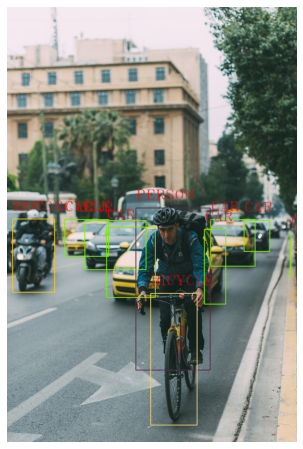

In [9]:
# loading model in tensorflow for making prediction
model = tf.saved_model.load('savedmodel')
infer = model.signatures["serving_default"]

# loading image and adding bbox
IMG_PATH = pathlib.Path(str(pathlib.Path.cwd().parent.parent) + '/test6.jpeg')
img = load_image(cpath=IMG_PATH)
output = infer(img)
output = output['detections:0'].numpy()
vis,_ = post_processing(cpath=IMG_PATH,pred=output,n_bbox=10,label=coco_label,label_color=label_color)

# showing figure with matplotlib
plt.figure(figsize=(8,8))
plt.imshow(vis)
plt.axis(False)
plt.show()

### Creating OpenVINO IR(Intermediate Representation) and compiling model
* Converting tensorflow SavedModel to OpenVINO IR with help of openvino-dev(mo) tools
* Above step will create a xml(network topology) and a bin(network weights) file which will be compiled with openvino runtime module

In [ ]:
!pip install openvino
!pip install openvino-dev[tensorflow2]

In [11]:
MODEL_DIR_PATH = pathlib.Path("savedmodel")
IR_PATH = str(pathlib.Path.cwd().parent.parent) + '/IR'
pathlib.Path(IR_PATH).mkdir(exist_ok=True)

mo_command = f"""mo\
                 --saved_model_dir="{MODEL_DIR_PATH}"\
                 --input_shape="[1,512,512,3]"\
                 --data_type=FP16\
                 --output_dir="{IR_PATH}"\
                 """

In [12]:
if not (pathlib.Path(IR_PATH) / 'saved_model.xml').exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    !{mo_command}
else:
    print(f"IR model {IR_PATH} already exists.")

IR model /content/IR already exists.


In [13]:
pathlib.os.chdir('../..')
from openvino.runtime import Core
ie = Core()
model = ie.read_model(model='IR/saved_model.xml',weights='IR/saved_model.bin')
compiled_model = ie.compile_model(model=model, device_name="CPU")

#### Testing OpenVINO IR compiled model
* Loading Image
* Producing result
* Visualizing result

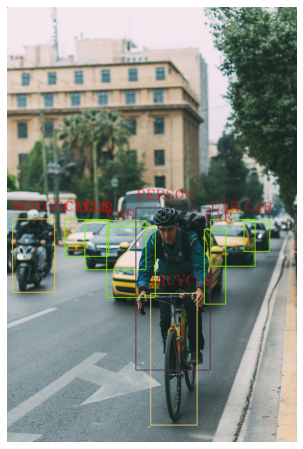

In [14]:
# loading image
IMG_PATH = pathlib.Path('test6.jpeg')
img = load_image(cpath=IMG_PATH)

# producing result
output_key = compiled_model.output(0)
result = compiled_model([img])[output_key]

# visulizing result
vis,_ = post_processing(cpath=IMG_PATH,pred=result,n_bbox=10,label=coco_label,label_color=label_color)
plt.figure(figsize=(8,8))
plt.imshow(vis)
plt.axis(False)
plt.show()

### Verify Accuracy of compiled model
* Since EfficientDet models are trained with COCO-2017 dataset , we will use it to verify accuracy
* To evaluate performance we will use mAP ie. mean Average precision 
* To calculate mAP we will use COCO official API `pycocotools`

In [15]:
from openvino.runtime import Model


def write_result(model:Model,image_dir:pathlib.Path,res_file:str,n_images:int = 100):
    """
    Create a JSON file to write predictions in COCO format to evalute mAP

    Parameters:
        model(Model) : openvino 
        images_dir(Path) : Path of images directory
        res_file(str) : result file name 
        n_images(int) : number of images for which predictions must be wrote (first n)
    
    Returns:
        NONE
    """

    results = []
    images = sorted(pathlib.os.listdir(image_dir))[:n_images]  # first n_images

    # loop for finding result for each of n_images
    for _,i in enumerate(images, start=1):

        complete_path = pathlib.Path(image_dir) / i
        img_tensor = load_image(cpath=complete_path)

        key = model.output(0)
        result = model([img_tensor])[key]

        __,predictions = post_processing(cpath=complete_path,pred=result,label=coco_label)

        for k in predictions:
            if sum(k[2]) != 0:
                cat_id ,score, bbox = k[0],k[1],k[2]
                r = {'score':np.float64(score),
                     'image_id':int(i[:len(i) - 4]),
                     'category_id':cat_id,
                     'bbox':[bbox[0],bbox[1],bbox[2] - bbox[0],bbox[3] - bbox[2]]}
                results.append(r)
            else:
                break

        if (_ % 10 == 0):
            print(f'{_}/{n_images} predictions stored ')
    
    with open(res_file,'w') as result_file:
        json.dump(results,result_file)

In [16]:
# Downloading Dataset and labels of COCO-VAL2017

from zipfile import ZipFile

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = pathlib.Path.cwd()

if not (OUT_DIR / "coco/labels").exists():
    download_file(URL=DATA_URL)
    download_file(URL=LABELS_URL)
    with ZipFile('coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile('val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

##### Evaluating Performance of OpenVINO model
* We will write results produced by model in COCO formant in a JSON file
* Then we will use COCO offcial API for model evaluation on COCO dataset

In [17]:
# writing predictions
images_folder = pathlib.Path('coco/images/val2017')
result_file = 'result.json'
write_result(model=compiled_model,image_dir=images_folder,res_file=result_file,n_images=100)

10/100 predictions stored 
20/100 predictions stored 
30/100 predictions stored 
40/100 predictions stored 
50/100 predictions stored 
60/100 predictions stored 
70/100 predictions stored 
80/100 predictions stored 
90/100 predictions stored 
100/100 predictions stored 


In [18]:
# Using COCO official API for model evaluation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annType = 'bbox'

cocoGT = COCO('coco/annotations/instances_val2017.json')
cocoDT = cocoGT.loadRes('result.json')

imgIds = sorted(cocoGT.getImgIds())
imgIds = imgIds[0:100]  # using first 100 ids as model is being evaluated on those images only

cocoEval = COCOeval(cocoGT,cocoDT,annType)
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=1.98s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### Optimize model using NNCF Post-training Quantization API
<a href='https://github.com/openvinotoolkit/nncf'>NNCF</a> provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop. We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize EfficientDet.

The optimization process contains the following steps:
1. Create Dataset for quantization
2. Run `nncf.quantize` for getting optimized model
3. Serialize OpenVINO IR model using openvino.runtime.serialize function

In [ ]:
# run to install NNCF(Neural Network Compression Framework)
!pip install nncf[openvino]

In [20]:
def transform_fn(data_item):
    """
    Create image tensor for quantization process

    Parameters:
        data_item : tensorflow dataset object
    
    Returns:
        img(tf.tensor) : tensor of image in shape (1,512,512,3)
    """
    data_item = pathlib.Path(data_item.numpy().decode('UTF8'))
    img = load_image(data_item) 
    return img

In [21]:
import nncf

/usr/local/lib/python3.8/dist-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, openvino


In [22]:
# creating dataset for accuracy testing
dataloader = tf.data.Dataset.list_files('coco/images/val2017/*.jpg',shuffle=False)  # itterable Data Object
quantization_dataset = nncf.Dataset(dataloader, transform_fn)

# loading original openvino-model for quantization
IR_PATH = pathlib.Path('IR')
OpenVino_model = ie.read_model(model=str(IR_PATH / 'saved_model.xml'),weights=str(IR_PATH / 'saved_model.bin'))

In [ ]:
# take long to execute , took me around 15 minutes
quantized_model = nncf.quantize(OpenVino_model, quantization_dataset)  
# specify `preset` in nncf.quantize() for better result , Default optimizer will be used otherwise

In [24]:
from openvino.runtime import serialize
serialize(quantized_model,'int8_IR/efficientDet-D0_int8.xml')

##### Validating Quantized model Inference

In [26]:
from openvino.runtime import Core
ie = Core()
model = ie.read_model(model='int8_IR/efficientDet-D0_int8.xml',weights='int8_IR/efficientDet-D0_int8.bin')
compiled_int_model = ie.compile_model(model=model, device_name="CPU")

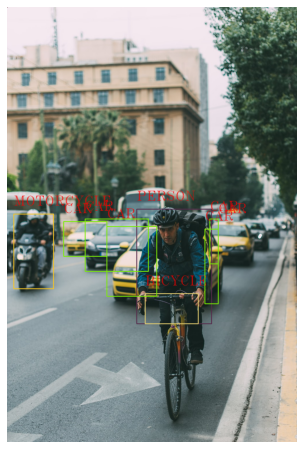

In [27]:
IMG_PATH = pathlib.Path('test6.jpeg')
img = load_image(cpath=IMG_PATH)

# producing result
output_key = compiled_int_model.output(0)
result = compiled_int_model([img])[output_key]

# visulizing result
vis,_ = post_processing(cpath=IMG_PATH,pred=result,n_bbox=10,label=coco_label,label_color=label_color)
plt.figure(figsize=(8,8))
plt.imshow(vis)
plt.axis(False)
plt.show()

##### Evaluating Performance of OpenVINO Quantized model

In [28]:
images_folder = pathlib.Path('coco/images/val2017')
result_file = 'result_int8.json'
write_result(model=compiled_int_model,image_dir=images_folder,res_file=result_file,n_images=100)

10/100 predictions stored 
20/100 predictions stored 
30/100 predictions stored 
40/100 predictions stored 
50/100 predictions stored 
60/100 predictions stored 
70/100 predictions stored 
80/100 predictions stored 
90/100 predictions stored 
100/100 predictions stored 


In [29]:
# Using COCO official API for model evaluation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annType = 'bbox'

cocoGT = COCO('coco/annotations/instances_val2017.json')
cocoDT = cocoGT.loadRes('result_int8.json')

imgIds = sorted(cocoGT.getImgIds())
imgIds = imgIds[0:100]

cocoEval = COCOeval(cocoGT,cocoDT,annType)
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=1.85s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.55s).
Accumulating evaluation results...
DONE (t=0.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### Benchmarking performance for comparison between Original and Quantized model

In [ ]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m IR/saved_model.xml -d CPU -api async

In [ ]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m int8_IR/efficientDet-D0_int8.xml -d CPU -api async